In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
import lightgbm as lgb
from tqdm.auto import tqdm

import hvplot.pandas

import warnings

warnings.filterwarnings("ignore")

In [3]:
DATA_ROOT   = Path('./data')
WORKING_DIR = Path('./')
STUDY_PATH = WORKING_DIR / 'studies'

In [4]:
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=False)

X = pd.read_parquet(DATA_ROOT / 'working_dataset.parquet')
y = pd.read_csv(DATA_ROOT / 'train_labels.csv').drop('imdb_score', axis=1)

In [5]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        try:
            y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        except AttributeError:
            y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [57]:
def train(params):
    fitted_models = [[] for _ in range(19)]
    y_preds = [[] for _ in range(19)]
    y_valids = [[] for _ in range(19)]


    for idx_train, idx_valid in tqdm(cv.split(X, y), total=n_splits):
        for i in range(19):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train, i]
            X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid, i]

            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[lgb.early_stopping(50, verbose=False)]
            )
            fitted_models[i].append(model)

            y_pred = model.predict(X_valid)


            y_preds[i] += y_pred.tolist()
            y_valids[i] += y_valid.tolist()

    model = [VotingModel(models) for models in fitted_models]

    return model, y_preds, y_valids

In [58]:
import joblib

# Create or load the study
def create_or_load_study(study_name, storage=None):
    try:
        study = joblib.load(f"{STUDY_PATH}/{study_name}.pkl")
        print(f"Loaded study '{study_name}' from file.")
    except FileNotFoundError:
        study = optuna.create_study(study_name=study_name, storage=storage, direction='minimize')
        print(f"Created new study '{study_name}'.")
    return study

# Function to save the study
def save_study(study, study_name):
    joblib.dump(study, f"{STUDY_PATH}/{study_name}.pkl")
    print(f"Study '{study_name}' saved to file.")

In [59]:
import optuna

def objective(trial):
    params = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': 20000,

            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbose': -1
        }

    model, cv_scores = train(params)

    #print(f'======= Mean of scores: {np.mean(cv_scores):.3f}±{2*np.std(cv_scores):.3f} =======')
    return np.mean(cv_scores)


study_name = 'optuna'
study = create_or_load_study(study_name)

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    #print(f"Best value: {study.best_value}, Best params: {trial.best_trial.params}")

    study_df = study.trials_dataframe()
    save_study(study, study_name)
    study_df.to_csv('optuna.csv', index=False)


# study.optimize(objective, n_trials=40, callbacks=[print_callback], n_jobs=1, show_progress_bar=True)

Loaded study 'optuna' from file.


In [61]:
params = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
#         'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
#         'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'verbose': -1
}
    
model, y_preds, y_valids = train(params)

  0%|          | 0/5 [00:00<?, ?it/s]

In [76]:
for i in range(19):
    try:
        auc = roc_auc_score(y_preds[i], y_valids[i])
    except ValueError:
        auc = 0
    acc = accuracy_score(y_preds[i], y_valids[i])
    print(f'{y.columns[i]}: AUC: {auc: .4f}, ACC: {acc: .4f}')

Action: AUC:  0.8145, ACC:  0.8518
Adventure: AUC:  0.8049, ACC:  0.8739
Animation: AUC:  0.9476, ACC:  0.9786
Comedy: AUC:  0.8017, ACC:  0.8106
Crime: AUC:  0.7871, ACC:  0.8791
Documentary: AUC:  0.9958, ACC:  0.9917
Drama: AUC:  0.7755, ACC:  0.7757
Family: AUC:  0.9077, ACC:  0.9585
Fantasy: AUC:  0.7706, ACC:  0.9133
Foreign: AUC:  0.0000, ACC:  0.9983
History: AUC:  0.8099, ACC:  0.9675
Horror: AUC:  0.8891, ACC:  0.9502
Music: AUC:  0.8186, ACC:  0.9686
Mystery: AUC:  0.7708, ACC:  0.9254
Romance: AUC:  0.7619, ACC:  0.8417
Science Fiction: AUC:  0.8757, ACC:  0.9385
Thriller: AUC:  0.7597, ACC:  0.8048
War: AUC:  0.8864, ACC:  0.9848
Western: AUC:  0.8525, ACC:  0.9893


In [77]:
import joblib
joblib.dump(model, './models/classification.pkl')

['./models/classification.pkl']

## Feature Importance

In [29]:
import shap

shap_acc = [None for _ in range(19)]
X_acc = [None for _ in range(19)]

for i, (idx_train, idx_valid) in tqdm(enumerate(cv.split(X, y)), total=n_splits):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    for j, estimator in enumerate(model.estimators[i].estimators_):
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_train)

        if shap_acc[j] is not None:
            shap_acc[j] = np.concatenate([shap_acc[j], shap_values])
        else:
            shap_acc[j] = shap_values

        if X_acc[j] is not None:
            X_acc[j] = pd.concat([X_acc[j], X_train])
        else:
            X_acc[j] = X_train

  0%|          | 0/5 [00:00<?, ?it/s]

/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.

/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.

/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.

/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/home/marco/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.

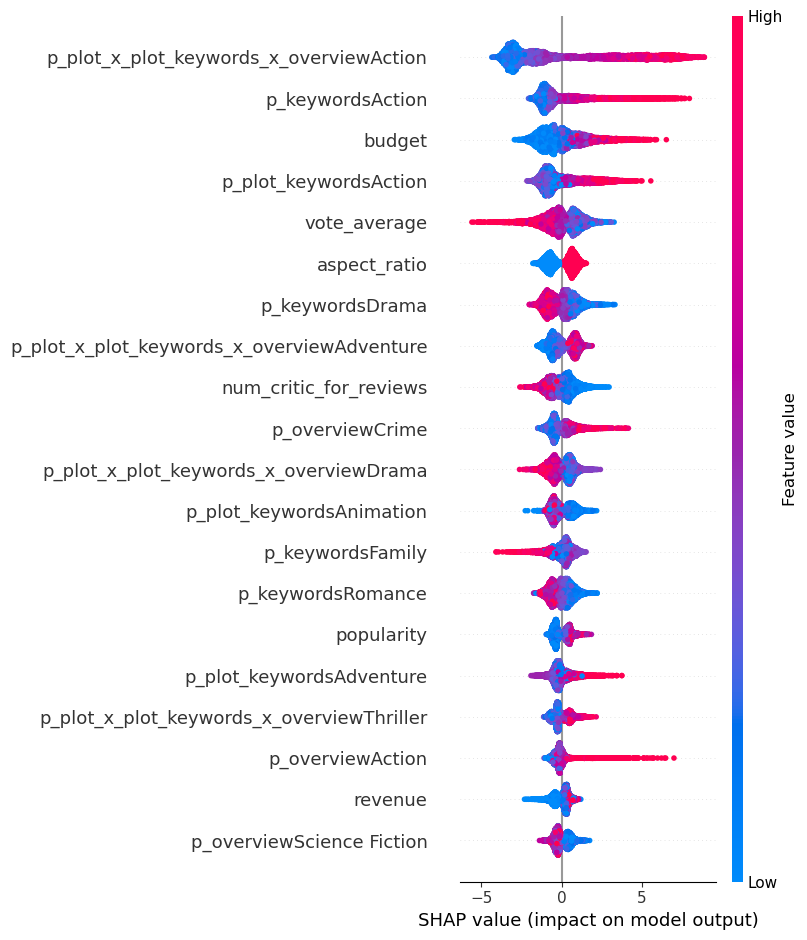

In [44]:
shap.summary_plot(shap_acc[0], X_acc[0])